In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt
from IPython import display
from torchsummary import summary

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = T.Compose([T.ToTensor(), # normalizes to range [0,1]
                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # further normalization
                       ])

train_set = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
test_set  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)

batchsize    = 32
train_loader = DataLoader(train_set,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_set, batch_size=128)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('Data shapes (train/test):')
print(train_set.data.shape)
print(test_set.data.shape)
print()

print('Data value range:')
print((np.min(train_set.data),np.max(train_set.data)))
print()

print('Data categories:')
print( train_set.classes )

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(0, 255)

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [5]:
X,y = next(iter(train_loader))

print('train/test shapes:')
print(X.data.shape)
print()

print('Value range:')
print((torch.min(X.data),torch.max(X.data)) )

train/test shapes:
torch.Size([32, 3, 96, 96])

Value range:
(tensor(-2.1179), tensor(2.6400))


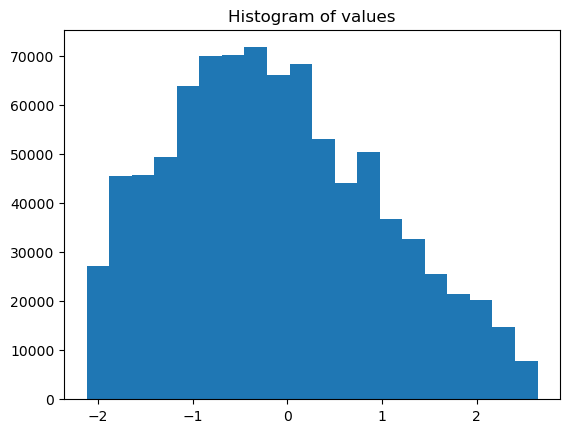

In [6]:
plt.hist(X.data.numpy().flatten(),20)
plt.title("Histogram of values")
plt.show()

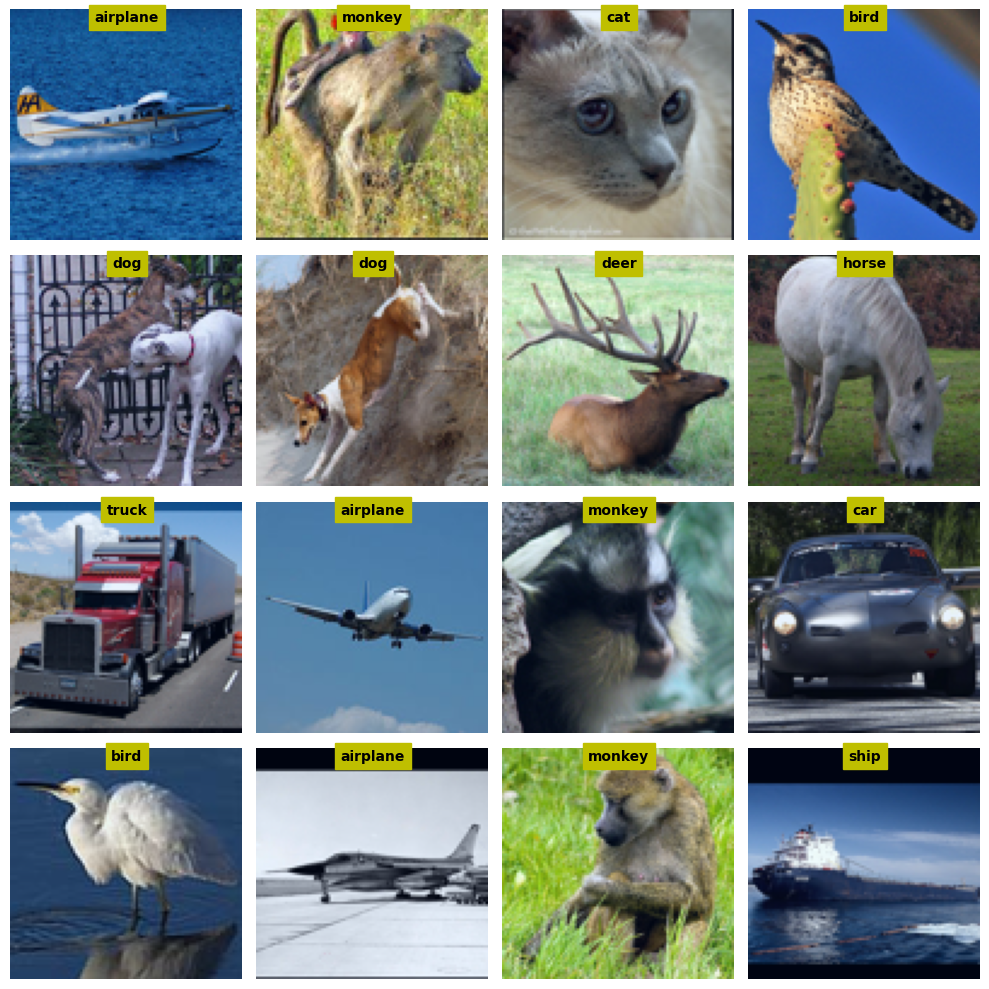

In [7]:
fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # From [channel, height, width] to [height, width, channel] (3x96x96 -> 96x96x3)
  img = X.data[i].numpy().transpose((1,2,0))
  img = img-np.min(img)
  img = img/np.max(img)
  
  label = train_set.classes[y[i]]

  ax.imshow(img)
  ax.text(48,0,label,ha='center',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
vggnet = torchvision.models.vgg16(pretrained=True)

summary(vggnet.to(device), (3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

In [11]:
for layer in vggnet.parameters():
    layer.requires_grad = False

In [12]:
vggnet.classifier[6] = nn.Linear(vggnet.classifier[6].in_features, 10)

In [13]:
summary(vggnet.to(device), (3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

In [14]:
for name, param in vggnet.named_parameters():
    print(f"{name}: {param.requires_grad}")

features.0.weight: False
features.0.bias: False
features.2.weight: False
features.2.bias: False
features.5.weight: False
features.5.bias: False
features.7.weight: False
features.7.bias: False
features.10.weight: False
features.10.bias: False
features.12.weight: False
features.12.bias: False
features.14.weight: False
features.14.bias: False
features.17.weight: False
features.17.bias: False
features.19.weight: False
features.19.bias: False
features.21.weight: False
features.21.bias: False
features.24.weight: False
features.24.bias: False
features.26.weight: False
features.26.bias: False
features.28.weight: False
features.28.bias: False
classifier.0.weight: False
classifier.0.bias: False
classifier.3.weight: False
classifier.3.bias: False
classifier.6.weight: True
classifier.6.bias: True


In [15]:
vggnet.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vggnet.parameters(), lr=.001)
EPOCHS = 20

train_loss = torch.zeros(EPOCHS)
train_acc = torch.zeros(EPOCHS)
test_loss = torch.zeros(EPOCHS)
test_acc = torch.zeros(EPOCHS)

for i in range(EPOCHS):
    vggnet.train()
    batch_loss = []
    batch_acc = []
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)

        y_hat = vggnet(X)
        loss = loss_fun(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())
        batch_acc.append(torch.mean((torch.argmax(y_hat,axis=1)==y).float()).item())

    train_loss[i] = np.mean(batch_loss)
    train_acc[i] = 100 * np.mean(batch_acc)

    vggnet.eval()
    batch_acc = []
    batch_loss = []
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        with torch.inference_mode():
            y_hat = vggnet(X)
            loss = loss_fun(y_hat, y)
        
        batch_loss.append(loss.item())
        batch_acc.append(torch.mean((torch.argmax(y_hat,axis=1)==y).float()).item())
    
    test_loss[i] = np.mean(batch_loss)
    test_acc[i] = 100 * np.mean(batch_acc)

    print(f"Epoch: {i+1} of {EPOCHS} | Train accuracy: {train_acc[i]} | Test accuracy: {test_acc[i]}")

Epoch: 1 of 20 | Train accuracy: 85.3165054321289 | Test accuracy: 90.63739776611328
Epoch: 2 of 20 | Train accuracy: 91.68669891357422 | Test accuracy: 90.89781951904297
Epoch: 3 of 20 | Train accuracy: 92.04727935791016 | Test accuracy: 90.46379089355469
Epoch: 4 of 20 | Train accuracy: 92.96875 | Test accuracy: 91.25743865966797
Epoch: 5 of 20 | Train accuracy: 93.38941955566406 | Test accuracy: 91.4310531616211
Epoch: 6 of 20 | Train accuracy: 94.47115325927734 | Test accuracy: 90.78620910644531
Epoch: 7 of 20 | Train accuracy: 94.59134674072266 | Test accuracy: 90.78620910644531
Epoch: 8 of 20 | Train accuracy: 94.89183044433594 | Test accuracy: 91.46825408935547
Epoch: 9 of 20 | Train accuracy: 94.99198913574219 | Test accuracy: 91.36904907226562
Epoch: 10 of 20 | Train accuracy: 95.29246520996094 | Test accuracy: 91.26984405517578
Epoch: 11 of 20 | Train accuracy: 95.71314239501953 | Test accuracy: 91.04662322998047
Epoch: 12 of 20 | Train accuracy: 95.29246520996094 | Test accu

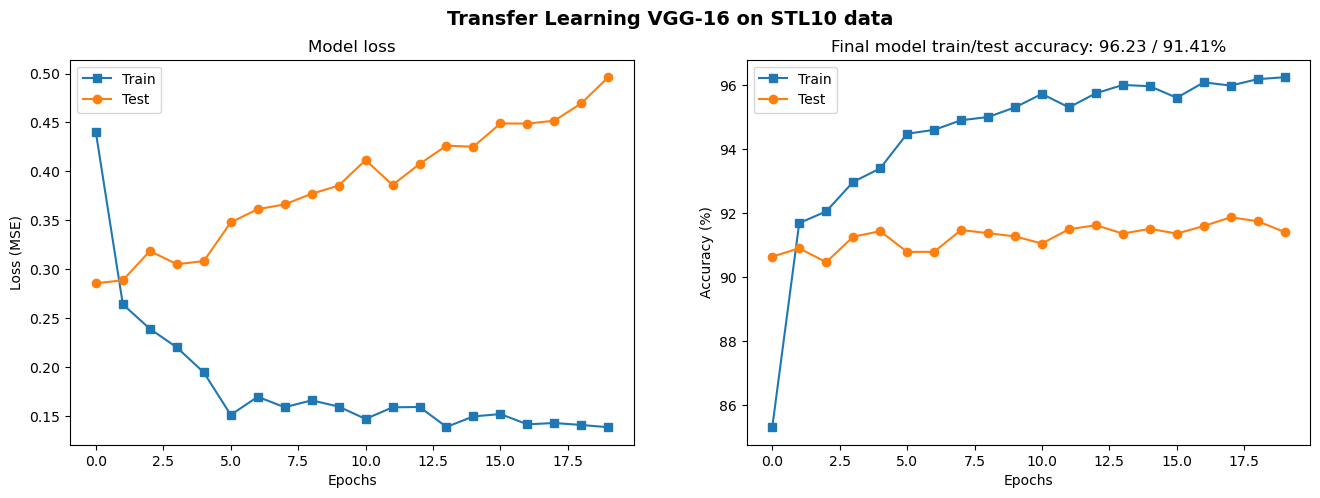

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_loss,'s-',label='Train')
ax[0].plot(test_loss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(train_acc,'s-',label='Train')
ax[1].plot(test_acc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {train_acc[-1]:.2f} / {test_acc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Transfer Learning VGG-16 on STL10 data',fontweight='bold',fontsize=14)
plt.show()